## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import json
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets

import config
from utils import *

os.environ['OPENAI_API_KEY'] = config.OPENAI_API_KEY

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## debug main

In [4]:
dataset = load_dataset(config.DATASET_NAME)
all_data = concatenate_datasets([dataset['test'], dataset['validation']])

In [5]:
print(all_data)

Dataset({
    features: ['name', 'formal_statement', 'informal_statement', 'tags', 'header', 'split'],
    num_rows: 234
})


In [6]:
item = all_data[0]
print(item)

results = []

{'name': 'f2f_numbertheory_4x3m7y3neq2003', 'formal_statement': 'theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 := by\n', 'informal_statement': '/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/\n', 'tags': "['number_theory']", 'header': 'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n', 'split': 'test'}


In [37]:
informal_statement = item['informal_statement'] #[4:-3]
print(informal_statement)

/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/



In [38]:
few_shot_examples = load_few_shot_examples(config.FEW_SHOT_EXAMPLES_PATH)
print(few_shot_examples)

[{'formal_statement': 'theorem exists_le_sylow [Group G] {P : Subgroup G} (hP : IsPGroup p P) : ∃ Q : Sylow p G, P ≤ Q :=', 'nl_statement': 'Let $P$ be a $p$-subgroup of $G$. Then $P$ is contained in a Sylow $p$-subgroup of $G$.'}, {'formal_statement': 'theorem exists_eq_const_of_bounded {E : Type u} [NormedAddCommGroup E] [NormedSpace ℂ E] {F : Type v} [NormedAddCommGroup F] [NormedSpace ℂ F] {f : E → F} (hf : Differentiable ℂ f)(hb : IsBounded (range f)) : ∃ c, f = const E c :=', 'nl_statement': 'Let $E$ and $F$ be complex normed spaces and let $f:E\\to F$. If $f$ is differentiable and bounded, then $f$ is constant'}, {'formal_statement': 'theorem subset_of_open_subset_is_open (X : Type*) [TopologicalSpace X]\n(A : Set X) (hA : ∀ x ∈ A, ∃ U : Set X, IsOpen U ∧ x ∈ U ∧ U ⊆ A):\n  IsOpen A :=', 'nl_statement': 'Let $X$ be a topological space; let $A$ be a subset of $X$. Suppose that for each $x\\in A$ there is an open set $U$ containing $x$ such that $U\\subset A$. Then $A$ is open in 

In [39]:
print(generate_prompt(informal_statement, few_shot_examples=few_shot_examples))

You are an expert in formalizing mathematical statements in Lean 4. Given the following informal mathematical statement, write the corresponding formal statement in Lean 4 syntax.
Output format: The translated LEAN 4 theorem should be provided as a single cohesive code block, displaying the correct syntax and formatting expected for a LEAN 4 theorem statement. Do not enclose the code block in backticks. write sorry as the proof.

Informal statement:
Let $P$ be a $p$-subgroup of $G$. Then $P$ is contained in a Sylow $p$-subgroup of $G$.

Formal statement in Lean 4:
theorem exists_le_sylow [Group G] {P : Subgroup G} (hP : IsPGroup p P) : ∃ Q : Sylow p G, P ≤ Q := sorry

Informal statement:
Let $E$ and $F$ be complex normed spaces and let $f:E\to F$. If $f$ is differentiable and bounded, then $f$ is constant

Formal statement in Lean 4:
theorem exists_eq_const_of_bounded {E : Type u} [NormedAddCommGroup E] [NormedSpace ℂ E] {F : Type v} [NormedAddCommGroup F] [NormedSpace ℂ F] {f : E → F}

In [40]:
formal_statement = translate_statement(
    informal_statement,
    few_shot_examples = [],
    model=config.DEFAULT_MODEL,
    temperature=0.0,
    max_tokens=500,
)

In [41]:
print(formal_statement)

theorem no_integers_satisfy_equation : ¬ ∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 := 
sorry


In [52]:
results.append({
    'name': item['name'],
    'informal_statement': informal_statement,
    'generated_formal_statement': formal_statement,
    'formal_statement': item['formal_statement'],
    'tags': item['tags'],
    'header': item['header'],
    'split': item['split'],
    'model': config.DEFAULT_MODEL,
    'provider': config.DEFAULT_PROVIDER,
})

In [53]:
results

[{'name': 'f2f_numbertheory_4x3m7y3neq2003',
  'informal_statement': '/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/\n',
  'generated_formal_statement': 'theorem no_integers_solution : ¬ ∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 := \nsorry',
  'formal_statement': 'theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 := by\n',
  'tags': "['number_theory']",
  'header': 'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n',
  'split': 'test',
  'model': 'gpt-4o',
  'provider': 'openai'}]

In [59]:
output_file = os.path.join(config.RESULTS_DIR, f"{config.OUTPUT_NAME}_{config.DEFAULT_MODEL}.json")

with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results have been saved to {output_file}")

Results have been saved to results/evaluation/baseline_direct_translation_gpt-4o.json


## checking results

In [42]:
json_file_path = 'results/generations/direct_translation_with_general_fewshot_gpt-4o.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,name,informal_statement,generated_formal_statement,formal_statement,tags,header,split,model,provider
0,f2f_numbertheory_4x3m7y3neq2003,/-- Show that there are no integers $x$ and $y...,theorem no_integers_satisfy_equation : ¬∃ (x y...,theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
1,f2f_mathd_numbertheory_3,/-- What is the units digit of the sum of the ...,theorem units_digit_sum_squares_first_nine : \...,theorem mathd_numbertheory_3 : (∑ x in Finset....,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
2,f2f_mathd_numbertheory_1124,/-- The four-digit number $\underline{374n}$ i...,theorem units_digit_of_divisible_by_18 : ∃ n :...,theorem mathd_numbertheory_1124 (n : ℕ) (h₀ : ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
3,f2f_mathd_numbertheory_237,/-- What is the modulo $6$ remainder of the su...,theorem sum_mod_six_remainder : (∑ i in Finset...,theorem mathd_numbertheory_237 : (∑ k in Finse...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
4,f2f_mathd_numbertheory_299,/-- What is the ones digit of $1 \cdot 3 \cdot...,theorem ones_digit_of_product_is_five : (1 * 3...,theorem mathd_numbertheory_299 : 1 * 3 * 5 * 7...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai


### Length

In [43]:
# Calculate the length of each 'generated_formal_statement'
df['gen_formal_stmt_length'] = df['generated_formal_statement'].apply(len)

# Compute the average length
average_length = df['gen_formal_stmt_length'].mean()
print(f"Average length of generated_formal_statement: {average_length:.2f} characters")


Average length of generated_formal_statement: 174.00 characters


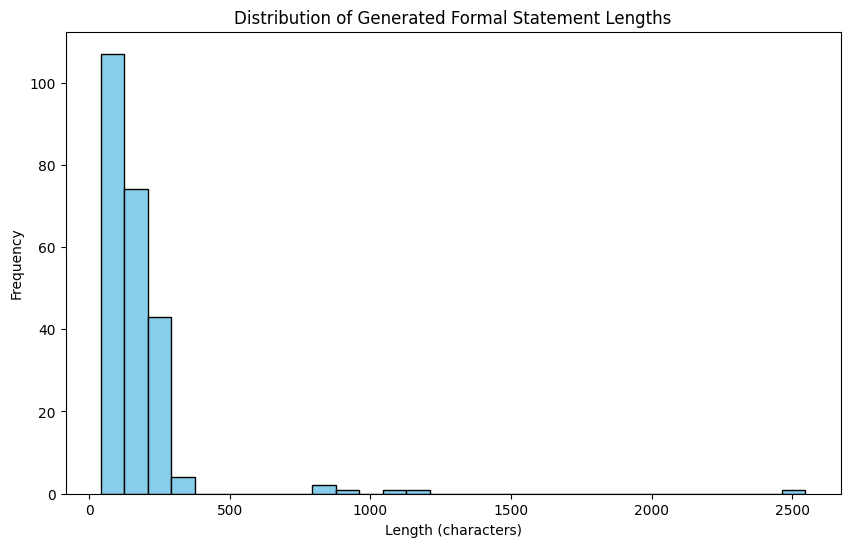

In [44]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(df['gen_formal_stmt_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Generated Formal Statement Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

### Sorry

In [45]:
# Define a function to check if text ends with 'sorry' (case-insensitive, optional punctuation)
def ends_with_sorry(text):
    text = text.strip()
    pattern = re.compile(r'sorry[\.\!\?]?$', re.IGNORECASE)
    return bool(pattern.search(text))

# Apply the function to the DataFrame
df['ends_with_sorry'] = df['generated_formal_statement'].apply(ends_with_sorry)

# Filter the DataFrame for statements that do not end with 'sorry'
not_sorry_df = df[~df['ends_with_sorry']]

# Reset the index
not_sorry_df = not_sorry_df.reset_index(drop=True)

# Display the number of examples
print(f"Number of statements not ending with 'sorry': {len(not_sorry_df)}")

# Display the first few examples
not_sorry_df[['name', 'generated_formal_statement']].head()

Number of statements not ending with 'sorry': 8


,name,generated_formal_statement
0,f2f_mathd_numbertheory_5,theorem smallest_integer_perfect_square_and_cu...
1,f2f_mathd_numbertheory_150,"theorem smallest_N_for_non_prime : ∃ N : ℕ, N ..."
2,putnam_2002_a5,theorem all_positive_rationals_in_sequence :\n...
3,putnam_2017_a1,To formalize the given informal statement in L...
4,f2f_mathd_numbertheory_33,"theorem find_inverse_modulo_398 : ∃ n : ℤ, 0 ≤..."


In [46]:
# Calculate the length of each 'generated_formal_statement'
not_sorry_df['gen_formal_stmt_length'] = not_sorry_df['generated_formal_statement'].apply(len)

# Compute the average length
average_length_not_sorry = not_sorry_df['gen_formal_stmt_length'].mean()
print(f"Average length of 'not sorry' generated_formal_statement: {average_length_not_sorry:.2f} characters")

Average length of 'not sorry' generated_formal_statement: 904.00 characters


In [51]:
print(df[df['name'] == 'f2f_mathd_numbertheory_150']['generated_formal_statement'].values[0])

theorem smallest_N_for_non_prime : ∃ N : ℕ, N > 0 ∧ ¬Nat.Prime (7 + 30 * N) ∧ ∀ M : ℕ, M > 0 → M < N → Nat.Prime (7 + 30 * M) :=
begin
  use 6,
  split,
  { exact Nat.succ_pos 5, },
  split,
  { norm_num, },
  { intros M hM hMN,
    interval_cases M,
    all_goals { norm_num, }, }
end


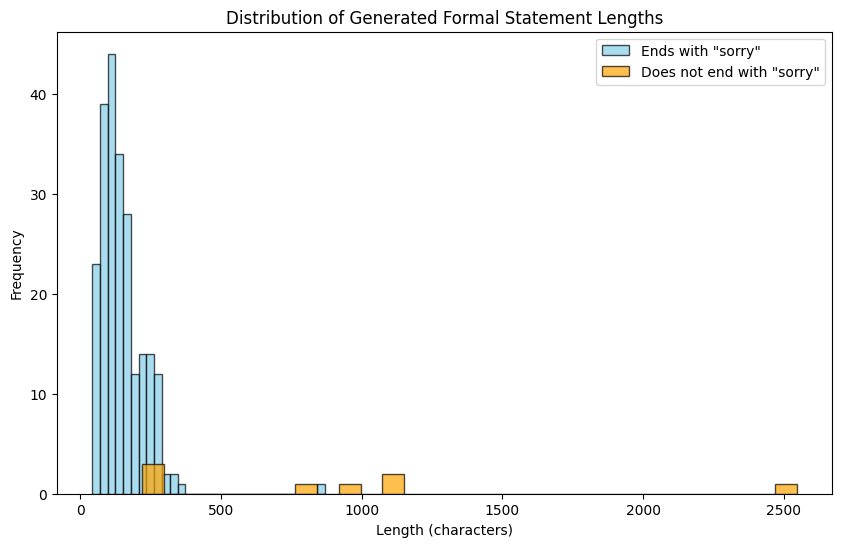

In [53]:
# Plot the distribution with different colors
plt.figure(figsize=(10, 6))

# Plot for statements ending with "sorry"
plt.hist(df[df['ends_with_sorry']]['gen_formal_stmt_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Ends with "sorry"')

# Plot for statements not ending with "sorry"
plt.hist(df[~df['ends_with_sorry']]['gen_formal_stmt_length'], bins=30, color='orange', edgecolor='black', alpha=0.7, label='Does not end with "sorry"')

plt.title('Distribution of Generated Formal Statement Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## debug eval

In [63]:
generated = clean_theorem_string(df.iloc[0].generated_formal_statement)
reference = clean_theorem_string(df.iloc[0].formal_statement)
print(f"Generated: \n{generated}\n\nReference: \n{reference}")

Generated: 
theorem dummy : ¬∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 :=
sorry

Reference: 
theorem dummy (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 :=
sorry
